In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 29.7 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# upload gesture_data.zip
# unzip folder into gesture_data

!gdown
!unzip -qq gesture_data.zip

In [ ]:
import numpy as np
import pandas as pd

# Define the gesture labels (directories)
GESTURES = ["thumbs_up", "peace", "stop", "fist", "pinch", "left", "right", "ok", "inver_ok", "L", "four", "six", "none"]  # Define your gestures here

# Initialize empty lists to hold the data and labels
all_landmarks = []
all_labels = []

# Base directory where gesture data is stored
base_dir = 'gesture_data'

# Loop through each gesture directory
for label, gesture in enumerate(GESTURES):
    gesture_dir = os.path.join(base_dir, gesture)

    # Iterate through all CSV files in the gesture directory
    for file in os.listdir(gesture_dir):
        if file.endswith('.csv'):
            # Load the CSV file
            filepath = os.path.join(gesture_dir, file)
            landmarks = pd.read_csv(filepath, header=None).values.flatten()  # Load and flatten
            all_landmarks.append(landmarks)

            # Create a one-hot encoded label
            label_one_hot = np.zeros(len(GESTURES))
            label_one_hot[label] = 1
            all_labels.append(label_one_hot)

# Convert lists to NumPy arrays
all_landmarks = np.array(all_landmarks)
all_labels = np.array(all_labels)

print(f"Loaded {len(all_landmarks)} samples.")


Loaded 7145 samples.


In [ ]:
def normalize_to_wrist(landmarks):
    wrist = landmarks[0]
    normalized_landmarks = landmarks - wrist
    return normalized_landmarks.flatten()

# Calculate finger angles (gesture-specific features)
def calculate_finger_angles(landmarks):
    angles = []
    for i in [4, 8, 12, 16, 20]:  # Thumb and fingertips
        v1 = landmarks[i - 2] - landmarks[0]
        v2 = landmarks[i] - landmarks[i - 2]
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(np.degrees(angle))
    return np.array(angles)

# Augment landmarks with noise
def add_noise(landmarks, noise_level=0.02):
    noise = np.random.normal(0, noise_level, landmarks.shape)
    return landmarks + noise

# Combine augmentation
def augment_landmarks(landmarks):
    augmented = [landmarks]
    augmented.append(add_noise(landmarks))
    return augmented

In [ ]:
# normalise data to wrist
all_landmarks_normalized = [normalize_to_wrist(landmarks.reshape(21, 3)) for landmarks in all_landmarks]
X = np.array(all_landmarks_normalized)
y = all_labels

In [ ]:
y_labels = np.argmax(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_labels, random_state=42
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_weights = compute_class_weight(
    'balanced', classes=np.arange(len(GESTURES)), y=y_labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Architecture

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(GESTURES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Callbacks for Best Model Saving and Early Stopping ===

checkpoint = ModelCheckpoint(
    'best_gesture_model.keras',  # Save the best model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Stop training if no improvement for 5 epochs
    restore_best_weights=True
)

# === Train the Model ===

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

# Save the final trained model
model.save('final_gesture_model.keras')
print("Final model saved as 'final_gesture_model.keras'.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
174/179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2801 - loss: 2.1547
Epoch 1: val_accuracy improved from -inf to 0.80826, saving model to best_gesture_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2862 - loss: 2.1379 - val_accuracy: 0.8083 - val_loss: 0.6429
Epoch 2/50
168/179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7717 - loss: 0.6904
Epoch 2: val_accuracy improved from 0.80826 to 0.90763, saving model to best_gesture_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7734 - loss: 0.6850 - val_accuracy: 0.9076 - val_loss: 0.3258
Epoch 3/50
169/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.4159
Epoch 3: val_accuracy improved from 0.90763 to 0.92722, saving model to best_gesture_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8699 - loss: 0.4147 - val_accuracy: 0.9272 - val_loss: 0.2439
Epoch 4/50
174/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8924 - loss: 0.3436
Epoch 4: val_accu

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0226
Test Accuracy: 0.9958012700080872


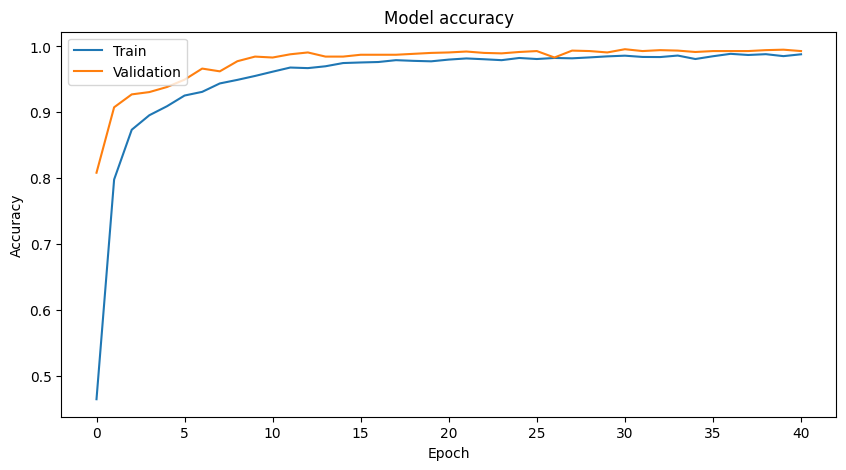

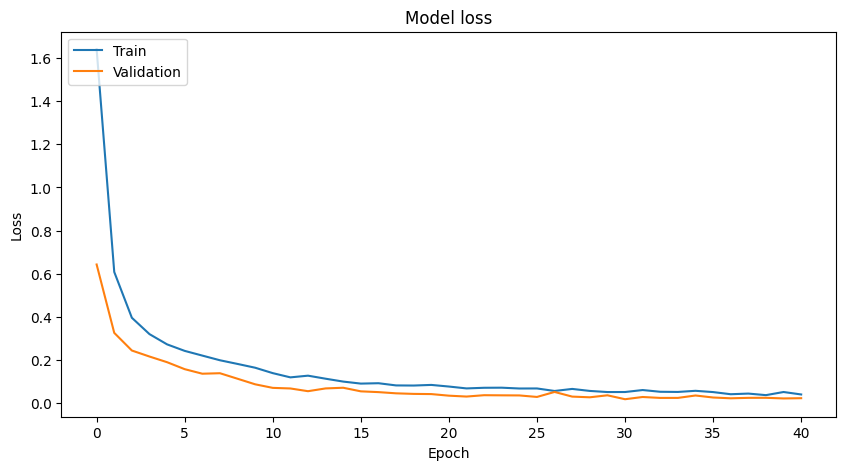

In [ ]:
# visualise training

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


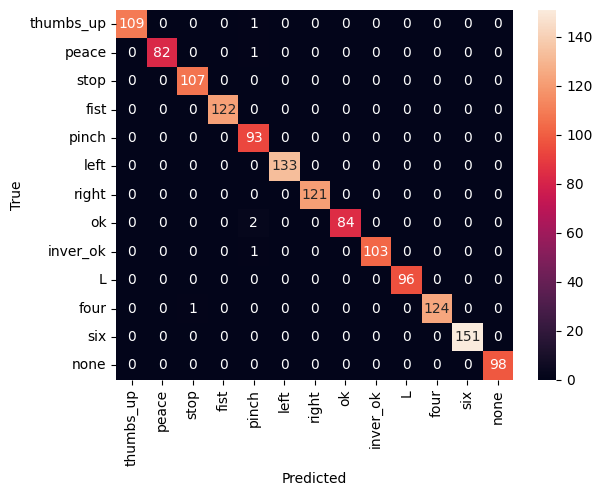

              precision    recall  f1-score   support

   thumbs_up       1.00      0.99      1.00       110
       peace       1.00      0.99      0.99        83
        stop       0.99      1.00      1.00       107
        fist       1.00      1.00      1.00       122
       pinch       0.95      1.00      0.97        93
        left       1.00      1.00      1.00       133
       right       1.00      1.00      1.00       121
          ok       1.00      0.98      0.99        86
    inver_ok       1.00      0.99      1.00       104
           L       1.00      1.00      1.00        96
        four       1.00      0.99      1.00       125
         six       1.00      1.00      1.00       151
        none       1.00      1.00      1.00        98

    accuracy                           1.00      1429
   macro avg       1.00      1.00      1.00      1429
weighted avg       1.00      1.00      1.00      1429



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print detailed metrics
print(classification_report(y_true, y_pred, target_names=GESTURES))


Filename: gesture_data/none/468.csv


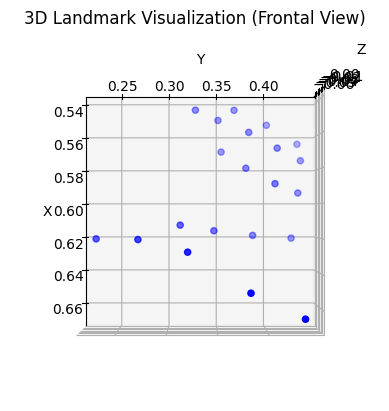

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# visualise data

sample_index = 9
landmarks = all_landmarks[sample_index].reshape(21, 3)
filename = ""
for label, gesture in enumerate(GESTURES):
    gesture_dir = os.path.join(base_dir, gesture)
    for file in os.listdir(gesture_dir):
      if file.endswith('.csv'):
        if sample_index == 0:
            filename = os.path.join(gesture_dir, file)
            break;
        else:
          sample_index -=1

print("Filename:", filename)


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates
x = landmarks[:, 0]
y = landmarks[:, 1]
z = landmarks[:, 2]


# Plot the landmarks
ax.scatter(x, y, z, c='b', marker='o')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Landmark Visualization (Frontal View)')
ax.view_init(elev=90, azim=0) # Frontal view


plt.show()